# Electrical Ports

Electrical ports are defined and used in a similar manner to optical [ports](Ports.ipynb): they are used to define default waveguides and electromagnetic ports for components.
The difference is that they are used for [electrical frequencies](../_autosummary/photonforge.frequency_classification.rst) and, therefore, require a few extra parameters for mode solving and impedance calculation, assuming the support confined TEM modes.

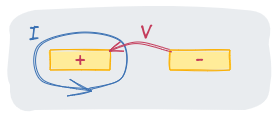

In [1]:
import numpy as np
import photonforge as pf
from matplotlib import pyplot as plt

## Electrical Specifications

PhotonForge's [basic technology](../_autosummary/photonforge.basic_technology.rst) includes an example of electrical for a CPW transmission line that we can inspect:

PortSpec(description="CPW transmission line", width=22.5, limits=(-5.48, 9.42), num_modes=1, added_solver_modes=1, polarization="", target_neff=4, path_profiles={"gnd1": (7.2, 7.9, (5, 0)), "gnd0": (7.2, -7.9, (5, 0)), "signal": (3.6, 0, (5, 0))}, voltage_path=[(4.3, 1.97), (1.8, 1.97)], current_path=[(3.05, 3.47), (-3.05, 3.47), (-3.05, 0.47), (3.05, 0.47)])

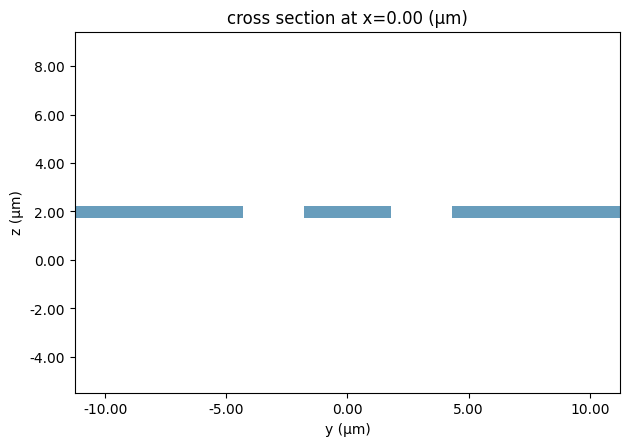

In [2]:
tech = pf.basic_technology()
pf.config.default_technology = tech

cpw_spec = tech.ports["CPW"]

_ = pf.tidy3d_plot(cpw_spec)
cpw_spec

We first note that the path profiles in electrical ports are usually named.
That is useful for creating terminals along the waveguide cross-section for routing, as we will see later.

Besides the parameters also found in optical [port specifications](../_autosummary/photonforge.PortSpec.rst), which have the same meaning, there are 2 extra:
- [voltage path](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.voltage_path)
- [current path](../_autosummary/photonforge.PortSpec.rst#photonforge.PortSpec.current_path)

Voltage and current paths define the integration paths for computing them from electric and magnetic fields.
They are needed for computing the line impedance for the port mode.

We can see those specifications by exporting and plotting an [impedance calculator](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.ImpedanceCalculator.html) from the port specification:

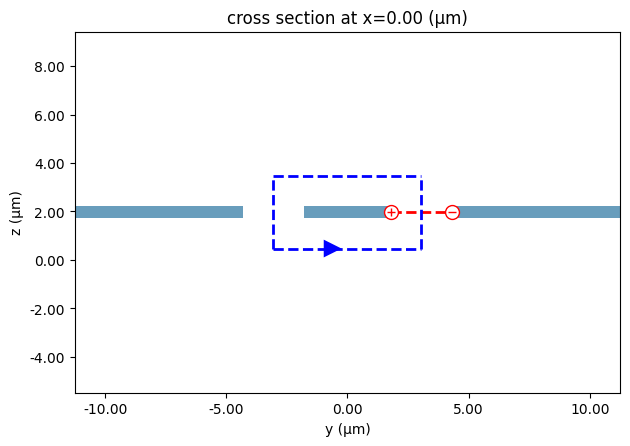

In [3]:
ic = cpw_spec.to_tidy3d_impedance_calculator()

ax = pf.tidy3d_plot(cpw_spec)
_ = ic.voltage_integral.plot(ax=ax, x=0)
_ = ic.current_integral.plot(ax=ax, x=0)

## Impedance Calculation

We can calculate the impedance of the port by using the previous impedance calculator and and passing the computed mode solver data to it, but an easier alternative is to directly compute it from the [port_modes](../_autosummary/photonforge.port_modes.rst) function:

Loading cached simulation from .tidy3d/pf_cache/GSS/ms_info-7SF63MAJORQNTHU2HMAC7PKFR5DAXGHCONN3VHEMPSVAETISPH5A.json.


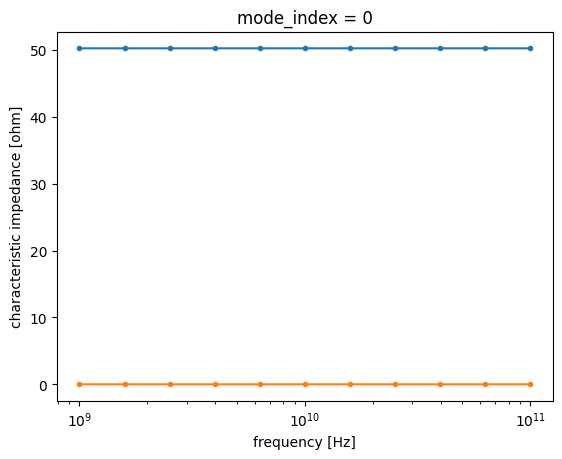

In [4]:
freqs = np.logspace(0, 2, 11) * 1e9

mode_solver, z0 = pf.port_modes(cpw_spec, freqs, impedance=True)

z0.isel(mode_index=0).real.plot(marker=".")
z0.isel(mode_index=0).imag.plot(marker=".")
plt.gca().set_xscale("log")

Of course, the field distributions can also be inspected to ensure the expected modes have been found.

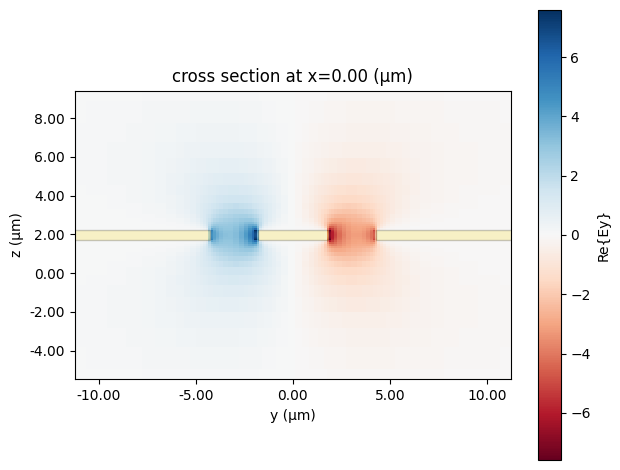

In [5]:
_ = mode_solver.plot_field("Ey", mode_index=0, f=freqs[0].item(), robust=False)

## Terminals

[Terminals](../_autosummary/photonforge.Terminal.rst) are objects that represent connection points in a component.
In practice, terminals are used to represent internal or external pads, vias, etc., usually for low-frequency connections, but also for connecting to individual terminals within a high-frequency electrical port.

They have a planar shape and a layer, used for the connection.
For example, this is a circular connection pad for the METAL layer:

In [6]:
terminal1 = pf.Terminal("METAL", pf.Circle(25))
terminal1

We can use one of the [routing](Routing_and_Connections.ipynb) functions to make a connection between terminals, [route_taper](../_autosummary/photonforge.parametric.route_taper.rst) in this case.
Note that we are adding the terminals back to the route just so that they are shown in the image.

In [7]:
terminal2 = pf.Terminal("METAL", pf.Rectangle(center=(80, 0), size=(20, 20)))

route = pf.parametric.route_taper(
    terminal1=terminal1, terminal2=terminal2, use_box=False
)
route.add_terminal([terminal1, terminal2])
route

Individual terminals from ports can be accessed when the path profiles in the port specifications were named:

In [8]:
port = pf.Port((0, 40), 90, cpw_spec)
port.terminals()

{'signal': Terminal(routing_layer=(5, 0), structure=Rectangle(center=(0, 40), size=(0, 3.6), rotation=90)),
 'gnd0': Terminal(routing_layer=(5, 0), structure=Rectangle(center=(7.9, 40), size=(0, 7.2), rotation=90)),
 'gnd1': Terminal(routing_layer=(5, 0), structure=Rectangle(center=(-7.9, 40), size=(0, 7.2), rotation=90))}

They can be used for connections as before:

In [9]:
gnd0_pad = pf.Terminal("METAL", pf.Circle(10, center=(30, 0)))
signal_pad = pf.Terminal("METAL", pf.Circle(10, center=(0, 0)))
gnd1_pad = pf.Terminal("METAL", pf.Circle(10, center=(-30, 0)))

component = pf.Component("Connections")

component.add_terminal([gnd0_pad, signal_pad, gnd1_pad])
component.add_port(port)

# Add routes
component.add(
    pf.parametric.route_taper(terminal1=gnd0_pad, terminal2=port.terminals("gnd0")),
    pf.parametric.route_taper(terminal1=signal_pad, terminal2=port.terminals("signal")),
    pf.parametric.route_taper(terminal1=gnd1_pad, terminal2=port.terminals("gnd1")),
)

component

More concrete use cases for terminals and electrical connections can be found in the [Quantum Chip](../examples/Quantum_Chip.ipynb) example.